In [2]:
import numpy as np
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
'''
CONST
'''
FILEPATH_STOCK_PRICE = "./tr_eikon_eod_data.csv"
STOCK_NAMES = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']

In [4]:
''' 
UTILS
'''
def sequential_train_test_split(data, ratio = 0.8):
    df = pd.DataFrame(data.dropna()).to_numpy()
    split_index = int(len(df) * ratio)
    return df[:split_index], df[split_index:]


In [5]:
'''
BENCHMARK
'''

def benchmark_accuracy(prediction, test):
    prediction = pd.DataFrame(prediction)
    test = pd.DataFrame(test)

    benchmark = np.where(
        test >= test.shift(1),
        1,
        -1
    )
    return (prediction == benchmark).sum() / len(prediction)


In [6]:
''' 
MODEL
'''

def predict_position(train, test):
    # Train Hidden Markov Model
    model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
    model.fit(train.reshape(-1, 1))

    # Predict hidden states for test data
    hidden_states = model.predict(test.reshape(-1, 1))

    # Define a function to map hidden states to rise or fall
    def map_to_rise_or_fall(state):
        return 1 if state == 0 else -1

    # Map hidden states to rise or fall
    predicted_rise_fall = np.array(list(map(map_to_rise_or_fall, hidden_states)))

    return predicted_rise_fall

In [7]:
apple_data = pd.read_csv('apple_output.csv', index_col = 0, parse_dates = True)
apple_data['direction'] = np.where(apple_data['AAPL.O'] >= apple_data['AAPL.O'].shift(1), 1, -1)
apple_data['direction'] = apple_data['direction'].shift(1) # shift because we use today's values to predict tomorrow's directions (tomorrow's values are not available yet)

apple_data

,AAPL.O,SlowK,SlowD,RSI,ADX,CCI,Aroon Down,Aroon Up,direction
Date,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,30.572827,78.7484,82.8722,75.0702,38.0954,96.8893,42.8571,100.0000,-1.0
2010-05-01,30.625684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2010-06-01,30.138541,89.5060,82.1665,57.5986,35.3551,151.4643,57.1429,100.0000,1.0
2010-07-01,30.082827,11.7287,14.7644,38.9499,24.7259,-152.8759,100.0000,42.8571,-1.0
...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,24.7765,28.7326,33.5305,28.2742,-132.0057,100.0000,14.2857,-1.0
2018-06-26,184.430000,30.9769,28.9171,32.5318,28.2014,-70.9622,92.8571,7.1429,-1.0
2018-06-27,184.160000,37.4891,31.0808,42.8627,27.4502,-43.5508,85.7143,0.0000,1.0


In [12]:
train_data, test_data = sequential_train_test_split(apple_data)
X_train, y_train, X_test, y_test = train_data[:, :-1], train_data[:, -1], test_data[:, :-1], test_data[:, -1]

In [13]:
len(X_train)
len(y_train)

1509

In [14]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=[200] * 2, random_state=1)
prediction = model.fit(X_train, y_train).predict(X_test)
benchmark_accuracy(prediction, y_test)

0    0.521164
dtype: float64

In [17]:
model = MLPClassifier(hidden_layer_sizes=[50] * 3, random_state=1)
prediction = model.fit(X_train, y_train).predict(X_test)
benchmark_accuracy(prediction, y_test)

0    0.616402
dtype: float64

In [10]:
results = [] # hyperparameter tuning
for n in range(10, 500, 10):
    for p in range(1, 11, 1):
        model = MLPClassifier(hidden_layer_sizes=[n] * p, random_state=1)
        prediction = model.fit(X_train, y_train).predict(X_test)
        acc = benchmark_accuracy(prediction, y_test)
        results.append([n, p, acc])
        print(results[-1])

[10, 1, 0    0.510582
dtype: float64]
[10, 2, 0    0.542328
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[10, 3, 0    0.55291
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[10, 4, 0    0.439153
dtype: float64]
[10, 5, 0    0.550265
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[10, 6, 0    0.555556
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[10, 7, 0    0.5
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[10, 8, 0    0.595238
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[10, 9, 0    0.439153
dtype: float64]
[10, 10, 0    0.468254
dtype: float64]
[20, 1, 0    0.433862
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[20, 2, 0    0.468254
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[20, 3, 0    0.404762
dtype: float64]
[20, 4, 0    0.431217
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[20, 5, 0    0.505291
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[20, 6, 0    0.441799
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[20, 7, 0    0.489418
dtype: float64]
[20, 8, 0    0.462963
dtype: float64]
[20, 9, 0    0.47619
dtype: float64]
[20, 10, 0    0.462963
dtype: float64]
[30, 1, 0    0.420635
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[30, 2, 0    0.433862
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[30, 3, 0    0.407407
dtype: float64]
[30, 4, 0    0.468254
dtype: float64]
[30, 5, 0    0.383598
dtype: float64]
[30, 6, 0    0.42328
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[30, 7, 0    0.544974
dtype: float64]
[30, 8, 0    0.486772
dtype: float64]
[30, 9, 0    0.417989
dtype: float64]
[30, 10, 0    0.534392
dtype: float64]
[40, 1, 0    0.391534
dtype: float64]
[40, 2, 0    0.494709
dtype: float64]
[40, 3, 0    0.325397
dtype: float64]
[40, 4, 0    0.481481
dtype: float64]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[40, 5, 0    0.388889
dtype: float64]
[40, 6, 0    0.55291
dtype: float64]
[40, 7, 0    0.42328
dtype: float64]
[40, 8, 0    0.444444
dtype: float64]
[40, 9, 0    0.383598
dtype: float64]
[40, 10, 0    0.335979
dtype: float64]
[50, 1, 0    0.579365
dtype: float64]
[50, 2, 0    0.518519
dtype: float64]
[50, 3, 0    0.616402
dtype: float64]
[50, 4, 0    0.380952
dtype: float64]
[50, 5, 0    0.529101
dtype: float64]
[50, 6, 0    0.34127
dtype: float64]
[50, 7, 0    0.44709
dtype: float64]
[50, 8, 0    0.497354
dtype: float64]
[50, 9, 0    0.465608
dtype: float64]
[50, 10, 0    0.402116
dtype: float64]
[60, 1, 0    0.544974
dtype: float64]
[60, 2, 0    0.531746
dtype: float64]
[60, 3, 0    0.333333
dtype: float64]
[60, 4, 0    0.452381
dtype: float64]
[60, 5, 0    0.5
dtype: float64]
[60, 6, 0    0.441799
dtype: float64]
[60, 7, 0    0.415344
dtype: float64]
[60, 8, 0    0.534392
dtype: float64]
[60, 9, 0    0.492063
dtype: float64]
[60, 10, 0    0.526455
dtype: float64]
[70, 1, 0    0.470

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[150, 5, 0    0.664021
dtype: float64]
[150, 6, 0    0.462963
dtype: float64]


In [17]:
hmm_model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
hmm_model.fit(train_data)

hidden_states = hmm_model.predict(test_data)

# Function to infer stock price movement based on hidden states
def infer_movement(hidden_states):
    movements = []
    for state in hidden_states:
        # This is a simplified example, you may need to adjust the logic
        if state == 0:
            movements.append(1)  # Assuming state 0 corresponds to rise
        else:
            movements.append(-1)  # Assuming state 1 corresponds to fall
    return movements

# Infer stock price movement for test data
predicted_movements = infer_movement(hidden_states)
benchmark_accuracy(predicted_movements, y_test)

0    0.5
dtype: float64

In [18]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X_train, y_train)
pred = model.predict(X_test)
benchmark_accuracy(pred, y_test)

0    0.531746
dtype: float64

In [45]:
raw = pd.read_csv(FILEPATH_STOCK_PRICE, index_col = 0, parse_dates = True)
apple_data = raw['AAPL.O']

train_data, test_data = sequential_train_test_split(apple_data)
prediction = predict_position(train_data, test_data)
len(apple_data)

2216

In [37]:
all_train_data = []

for stock_name in STOCK_NAMES:
    data = raw[stock_name]
    train_data, _ = sequential_train_test_split(data)
    all_train_data.append(train_data)

In [43]:
accuracies = []
for train_data in all_train_data:
    prediction = predict_position(train_data, test_data)
    accuracy = benchmark_accuracy(prediction, test_data)
    print(accuracy)


0    0.516355
dtype: float64
0    0.471963
dtype: float64
0    0.528037
dtype: float64
0    0.528037
dtype: float64
0    0.490654
dtype: float64


In [35]:
benchmark_accuracy(prediction, test_data)

0    0.528037
dtype: float64

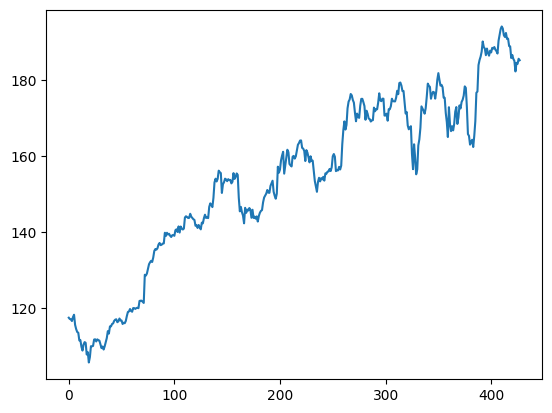

In [29]:
plt.plot(test_data)

In [23]:
len(test_data)

428

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [130]:
raw = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)
raw

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4323,1096.35,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.15,221.54,271.00,2717.07,17.33,1.1702,1265.00,22.01,119.89
2018-06-26,184.430000,99.080,49.67,1691.09,221.58,271.60,2723.06,15.92,1.1645,1258.64,21.95,119.26
2018-06-27,184.160000,97.540,48.76,1660.51,220.18,269.35,2699.63,17.91,1.1552,1251.62,21.81,118.58


In [12]:
def extract_train_and_test_data(data):
    return np.split(data.dropna().to_numpy(), 2)

def predict_position(train, test):
    # Train Hidden Markov Model
    model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=1000)
    model.fit(train.reshape(-1, 1))

    # Predict hidden states for test data
    hidden_states = model.predict(test.reshape(-1, 1))

    # Define a function to map hidden states to rise or fall
    def map_to_rise_or_fall(state):
        return "Rise" if state == 0 else "Fall"

    # Map hidden states to rise or fall
    predicted_rise_fall = np.array(list(map(map_to_rise_or_fall, hidden_states)))

    return predicted_rise_fall

def trade(balance, test, prediction):
    position = 0

    for today in range(len(test) - 1):
        tomorrow = today + 1
        if prediction[tomorrow] == "Rise":
            balance -= (1 - position) * test[today]
        else:
            balance += (position + 1) * test[today]
    
    balance += position * test[-1]

    return balance

def backtest(data):
    train_data, test_data = extract_train_and_test_data(data)

    N = 1000
    profit = 0
    for _ in range(N):
        prediction = predict_position(train_data, test_data)
        profit += trade(0, test_data, prediction)

    return profit / N

def run_simulation():
    raw = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)
    stock_names = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
    # stock_names = ['AMZN.O']
    for stock_name in stock_names:
        print(f"{stock_name}: ${backtest(raw[stock_name])}")

In [221]:
run_simulation()

AAPL.O: $25898.205453573253
MSFT.O: $2129.5166480000007
INTC.O: $9980.475258600052
AMZN.O: $17844.423592000006
GS.N: $-36143.16516000001


In [226]:
raw = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)
apple_train_data, _ = extract_train_and_test_data(raw['AAPL.O'])
_, goldmann_test_data = extract_train_and_test_data(raw['GS.N'])

N = 1000
profit = 0
for _ in range(N):
    prediction = predict_position(apple_train_data, goldmann_test_data)
    profit += trade(0, goldmann_test_data, prediction)

print(profit / N)

29677.512099999945


In [229]:
def run_simulation_2():
    stock_names = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
    raw = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)
    raw = raw[stock_names]
    raw = raw.dropna()

    all_predictions = {}
    all_train_data = {}
    all_test_data = {}
    N = 1000

    for stock_name in stock_names:
        train_data, test_data = extract_train_and_test_data(raw[stock_name])
        all_train_data[stock_name] = train_data
        all_test_data[stock_name] = test_data
        all_predictions[stock_name] = []
        for _ in range(N):
            all_predictions[stock_name].append(predict_position(train_data, test_data))
    
    def calculate_profit(test, prediction):
        balance = 0
        position = 0

        for today in range(len(test) - 1):
            tomorrow = today + 1
            if prediction[tomorrow] == "Rise":
                balance -= (1 - position) * test[today]
            else:
                balance += (position + 1) * test[today]
        
        balance += position * test[-1]

        return balance
    
    total_profit = 0
    for stock_name in stock_names:
        print(stock_name)
        best_profit = -float('inf')
        for other_stock_name in stock_names:
            profit = 0
            for prediction in all_predictions[other_stock_name]:
                profit += calculate_profit(all_test_data[stock_name], prediction)
            profit = profit / N
            print(f"{other_stock_name} {profit}")
            best_profit = max(profit, best_profit)
        print(best_profit)
        total_profit += best_profit
    print(f"total: {total_profit}")

In [230]:
run_simulation_2()

AAPL.O
AAPL.O 25985.29352180123
MSFT.O 3414.19760523545
INTC.O 33926.50375862077
AMZN.O 70.2750722065244
GS.N -21917.342845407937
33926.50375862077
MSFT.O
AAPL.O 12294.226189000055
MSFT.O 1617.7773159999997
INTC.O 16069.162077000099
AMZN.O 51.437720000000745
GS.N -10208.978761000004
16069.162077000099
INTC.O
AAPL.O 7386.089202400018
MSFT.O 970.7153455999982
INTC.O 9641.54737020004
AMZN.O 18.747831000000346
GS.N -6272.111987600012
9641.54737020004
AMZN.O
AAPL.O 151746.46054599996
MSFT.O 20037.396482000004
INTC.O 198938.60825999937
AMZN.O 990.8663179999922
GS.N -121335.578
198938.60825999937
GS.N
AAPL.O 41245.020420000044
MSFT.O 5408.518340000005
INTC.O 53786.47126000027
AMZN.O 95.56859999999847
GS.N -35035.120339999994
53786.47126000027
total: 312362.29272582056


In [224]:
import numpy as np
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Generate some example data
np.random.seed(42)
num_days = 100
num_stocks = 5
stock_prices = pd.read_csv('tr_eikon_eod_data.csv', parse_dates=True)
#stock_prices = stock_prices[['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']].dropna().to_numpy()
stocks = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
stock_prices = stock_prices[['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']].dropna().to_numpy()
stock_prices = stock_prices.reshape(-1, 1)
stock_prices = pd.DataFrame(stock_prices)



data = pd.read_csv('tr_eikon_eod_data.csv', parse_dates=True)
data = data[['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']]

# Initialize variables
current_balance = 0
position = None
value = 0

# Function to calculate profit based on transaction type
def calculate_profit(transaction_type, price, change = False):
    global current_balance, position, value
    price = float(price)
    if transaction_type == "buy":
        if change :
            position = "long"  
            current_balance -= price*value
        current_balance -= price  # Buying for $100
    elif transaction_type == "sell":
        if change : 
            position = "short" 
            current_balance += price*value
        current_balance += price  # Selling short for $100
    
    if change : 
        value = 1
    else :
        value += 1

def calculate(predicted_states, test_data) :
  global position, value, current_balance
  position = None
  value = 0
  current_balance = 0

  temp = np.hstack([predicted_states.reshape(-1,1), test_data.to_numpy()])
  for state, price in temp :
    try :
        price = float(price)
    except :
        continue
    if state == 0:  # Buy
        if position == "long":  # No position, buy
            calculate_profit("buy", price)
        if position == "short" or position is None:  # No position, buy
            calculate_profit("buy", price, True)
    else:  # Sell (short)
        if position == "short":  # Shorting when there's a position
            calculate_profit("sell", price)
        if position == "long" or position is None:  # Shorting when there's a position
            calculate_profit("sell", price, True)
    

for i in stocks :
  stock_prices = pd.read_csv('tr_eikon_eod_data.csv', parse_dates=True)
  stock_prices = stock_prices[i].dropna().to_numpy()
  stock_prices = stock_prices.reshape(-1, 1)
  stock_prices = pd.DataFrame(stock_prices)
  print(i)
  
  train_data = stock_prices
  test_data = stock_prices

  model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
  model.fit(train_data)

  total = 0

  for j in stocks :
    test_data = data[j].dropna().to_numpy()
    test_data = test_data.reshape(-1, 1)
    test_data = pd.DataFrame(test_data)

    predicted_states = model.predict(test_data)

    calculate(predicted_states, test_data)

    multiplier = 0
    if position == "long" :
        multiplier = 1
    else :
        multiplier = -1
        
    final_balance = current_balance + test_data.iloc[-1, 0] * value * multiplier
    total += final_balance
    print(i, j, final_balance)
  print(total)


AAPL.O
AAPL.O AAPL.O 27853.361191936856
AAPL.O MSFT.O -96435.26540000005
AAPL.O INTC.O -43499.33809999993
AAPL.O AMZN.O 2605379.555300001
AAPL.O GS.N 107605.82999999926
2600904.142991937
MSFT.O
MSFT.O AAPL.O -184803.37943080335
MSFT.O MSFT.O -41220.69559999986
MSFT.O INTC.O 12020.668100000035
MSFT.O AMZN.O -2606946.2453000005
MSFT.O GS.N -107656.37999999925
-2928606.0322308033
INTC.O
INTC.O AAPL.O -195801.72009076882
INTC.O MSFT.O -78245.98539999982
INTC.O INTC.O -8896.086700000007
INTC.O AMZN.O -2606946.2453000005
INTC.O GS.N -107656.37999999925
-2997546.4174907687
AMZN.O
AMZN.O AAPL.O 195956.31012128887
AMZN.O MSFT.O 115556.51539999993
AMZN.O INTC.O 43499.33809999993
AMZN.O AMZN.O -395851.60470000096
AMZN.O GS.N 107656.37999999925
66816.93892128702
GS.N
GS.N AAPL.O -195956.31012128887
GS.N MSFT.O -115556.51539999993
GS.N INTC.O -43499.33809999993
GS.N AMZN.O -580151.1991
GS.N GS.N -84820.80999999981
-1019984.1727212885
